<a href="https://colab.research.google.com/github/OseiasBeu/Data-Science/blob/master/PreverPercentualDeAberturaDeEmails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas Utilizadas
Sessão para importar as bibliotecas que utilizarei. 

In [168]:
!pip install graphviz==0.10
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [169]:
from sklearn.tree import export_graphviz
import  graphviz

In [73]:
from google.oauth2 import service_account
import pandas_gbq
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

# Extração do Dataset

### Primeira query:
Essa query possui apenas as informações de entregabilidade.

In [2]:
query_string = '''
with baseEmail AS (
SELECT 
SubscriberKey
,Envios
,Entregas
,DomainSent
,CASE
  WHEN LOWER(DomainSent) LIKE '%gmail.com%' THEN 1
  WHEN LOWER(DomainSent) LIKE '%outlook.com%' THEN 2
  WHEN LOWER(DomainSent) LIKE '%hotmail.com%' THEN 3
  WHEN LOWER(DomainSent) LIKE '%yahoo.com%' THEN 4
  WHEN LOWER(DomainSent) LIKE '%uol.com%' THEN 5
  WHEN LOWER(DomainSent) LIKE '%icloud%' THEN 6
  WHEN LOWER(DomainSent) LIKE '%bol.com%' THEN 7
  WHEN LOWER(DomainSent) LIKE '%ig.com%' THEN 8
  WHEN LOWER(DomainSent) LIKE '%terra.com%' THEN 9
  WHEN LOWER(DomainSent) LIKE '%live.com%' THEN 10
  WHEN LOWER(DomainSent) LIKE '%msn.com%' THEN 11
  WHEN LOWER(DomainSent) LIKE '%me.com%' THEN 12  
  ELSE 0
  END Domain_class
,BU
,Aberturas
FROM crm-datamart-prd.auxiliares.BASE_EMAIL_SMS
where status IN('active')
and canal IN ("Email")
) select * from baseEmail;
'''

### Segunda query:
Nessa segunda query fiz o cruzamento com a dimensão paciente do datamart para conseguir idade, genero e o id_mdm.

In [3]:
query_string_v2 = '''
with baseEmail AS (
SELECT 
SubscriberKey
,Envios
,Entregas
,DomainSent
,CASE
  WHEN LOWER(DomainSent) LIKE '%gmail.com%' THEN 1
  WHEN LOWER(DomainSent) LIKE '%outlook.com%' THEN 2
  WHEN LOWER(DomainSent) LIKE '%hotmail.com%' THEN 3
  WHEN LOWER(DomainSent) LIKE '%yahoo.com%' THEN 4
  WHEN LOWER(DomainSent) LIKE '%uol.com%' THEN 5
  WHEN LOWER(DomainSent) LIKE '%icloud%' THEN 6
  WHEN LOWER(DomainSent) LIKE '%bol.com%' THEN 7
  WHEN LOWER(DomainSent) LIKE '%ig.com%' THEN 8
  WHEN LOWER(DomainSent) LIKE '%terra.com%' THEN 9
  WHEN LOWER(DomainSent) LIKE '%live.com%' THEN 10
  WHEN LOWER(DomainSent) LIKE '%msn.com%' THEN 11
  WHEN LOWER(DomainSent) LIKE '%me.com%' THEN 12  
  ELSE 0
  END Domain_class
,BU
,Aberturas
FROM crm-datamart-prd.auxiliares.BASE_EMAIL_SMS
where status IN('active')
and canal IN ("Email")
) select * from baseEmail
JOIN   (select * from (
          select distinct
            mdm_people_id
            ,patient_age
            ,origin_gender
            ,UPPER(SUBSTRING(REPLACE(origin_name, ' ', ''), 1, 15)) || concat(SUBSTR(cast(origin_birth_date as string),9,2), "", SUBSTR(cast(origin_birth_date as string),6,2), "", SUBSTR(cast(origin_birth_date as string),0,4)) as pacid
            FROM   `interoper-dataplatform-prd.idd_bi_container_dimensions.idd_bi_dim_patient` 
        -- where UPPER(SUBSTRING(REPLACE(origin_name, ' ', ''), 1, 15)) || concat(SUBSTR(cast(origin_birth_date as string),9,2), "", SUBSTR(cast(origin_birth_date as string),6,2), "", SUBSTR(cast(origin_birth_date as string),0,4)) like 'FLAVIAMOREIRACO16081982'
              WHERE mdm_people_id IS NOT null
              AND origin_gender IS NOT null
          ) AS dim_patient 
  )AS dim_patient
  ON baseEmail.SubscriberKey = dim_patient.pacid 
'''

In [4]:
from google.oauth2 import service_account
import pandas_gbq

def connectBigQuery(query):
    # print(query)
    key_path = "/content/serviceAccount.json"
    credentials = service_account.Credentials.from_service_account_file(key_path)
    # print(credentials)
    df = pandas_gbq.read_gbq(query,project_id=credentials.project_id,credentials=credentials)
    return df


if __name__ == '__main__':
    df = connectBigQuery(query_string_v2)
    df.head(5)

Downloading: 100%|██████████| 1617269/1617269 [02:55<00:00, 9233.87rows/s]


### Removendo duplicidades com base no ID.

In [5]:
print(f'Quantidade de registros na extração: {df.shape}')
df = df.drop_duplicates(subset=['mdm_people_id'])
print(f'Quantidade de regsitros após a remoção de duplicidades: {df.shape}')

Quantidade de registros na extração: (1617269, 11)
Quantidade de regsitros após a remoção de duplicidades: (725735, 11)


# Analises descritivas

Informações básicas do dataset, como tipos de dados e contage mde valores não nulos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725735 entries, 0 to 1617266
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   SubscriberKey  725735 non-null  object
 1   Envios         725735 non-null  int64 
 2   Entregas       725735 non-null  int64 
 3   DomainSent     725735 non-null  object
 4   Domain_class   725735 non-null  int64 
 5   BU             725735 non-null  object
 6   Aberturas      725735 non-null  int64 
 7   mdm_people_id  725735 non-null  int64 
 8   patient_age    725735 non-null  int64 
 9   origin_gender  725735 non-null  object
 10  pacid          725735 non-null  object
dtypes: int64(6), object(5)
memory usage: 66.4+ MB


### Verificando features com valores nulos:
Desse modo podemos identificar com quais tipos de dados estamos trabalhando e além disso, verificar se existem dados nulos dentro do nosso dataset. Com essa visão já podemos dizer que temos sim. Agora, vamos fazer uma contagem e identificar exatamente quais são esses caras.

In [7]:
df.isnull().sum()

SubscriberKey    0
Envios           0
Entregas         0
DomainSent       0
Domain_class     0
BU               0
Aberturas        0
mdm_people_id    0
patient_age      0
origin_gender    0
pacid            0
dtype: int64

### Estatísticas básicas do dataset

In [8]:
df.describe()

,Envios,Entregas,Domain_class,Aberturas,mdm_people_id,patient_age
count,725735.0,725735.000000,725735.000000,725735.000000,7.257350e+05,725735.000000
mean,1.0,0.989838,2.160317,0.228352,1.352645e+07,48.444598
std,0.0,0.100294,1.746286,0.419771,8.505843e+06,13.491253
min,1.0,0.000000,0.000000,0.000000,5.078200e+04,0.000000
25%,1.0,1.000000,1.000000,0.000000,6.782033e+06,40.000000
50%,1.0,1.000000,1.000000,0.000000,1.259325e+07,47.000000
75%,1.0,1.000000,3.000000,0.000000,1.754821e+07,58.000000
max,1.0,1.000000,12.000000,1.000000,3.430579e+07,122.000000


### Média de idade do dataset

In [9]:
df.patient_age.mean()

48.44459754593619

### Agrupamentos de alguns campos:

In [10]:
df.groupby('Aberturas').count()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,mdm_people_id,patient_age,origin_gender,pacid
Aberturas,,,,,,,,,,
0,560012,560012,560012,560012,560012,560012,560012,560012,560012,560012
1,165723,165723,165723,165723,165723,165723,165723,165723,165723,165723


In [11]:
df.groupby('Envios').count()

,SubscriberKey,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid
Envios,,,,,,,,,,
1,725735,725735,725735,725735,725735,725735,725735,725735,725735,725735


In [12]:
df.groupby('BU').sum()

,Envios,Entregas,Domain_class,Aberturas,mdm_people_id,patient_age
BU,,,,,,
DASA - DELBONI AURIEMO,434802,428842,946673,115405,5640644300870,22602665
DASA - SP,290933,289518,621145,50318,4175976442951,12555275


#### Tratar esse campo:
* Gerar classes
* Corrigir acronimos

In [13]:
df.groupby(['origin_gender']).sum()

,Envios,Entregas,Domain_class,Aberturas,mdm_people_id,patient_age
origin_gender,,,,,,
,2,2,7,1,19617950,138
,1,1,1,0,3893388,68
F,327409,323859,710174,77748,4750292001179,16076389
FEMALE,957,955,1895,255,12825190007,44055
FEMININO,270857,267902,588186,64696,3283754289121,13319070
G,1,1,3,0,6146087,30
I,309,303,736,69,5194564693,14836
INDETERMINADO,3,3,7,0,53992227,197
INTERSEXUAL,148,145,401,26,2002968799,6415


### Classes de dominio:
Não vamos precisar tratar o campo `Domain_class` pois já o fizemos na extração do banco:

- 0 - Outros;
- 1 - Gmail;
- 2 - Outlook;
- 3 - Hotmail;
- 4 - Yahoo;
- 5 - Uol;
- 6 - Icloud;
- 7 - BOl;
- 8 - Ig;
- 9 - Terra;
- 10 - Live;
- 11 - Msn;
- 12 - Me;

In [14]:
df.groupby(['Domain_class']).sum()

,Envios,Entregas,Aberturas,mdm_people_id,patient_age
Domain_class,,,,,
0,47418,45041,8079,597082228324,2418036
1,348698,348321,115712,4822445669181,16794482
2,11534,11524,917,173337380173,479988
3,205851,205201,13039,2778792045241,9718025
4,61385,60491,16245,802680143454,3032651
5,25388,24837,6206,313694593032,1452128
6,4265,4261,3021,61002424914,184110
7,6546,6179,638,85785709033,337913
8,6327,5286,366,75205874377,335220


In [15]:
df.value_counts('Domain_class')

Domain_class
1     348698
3     205851
4      61385
0      47418
5      25388
2      11534
7       6546
8       6327
6       4265
9       3040
10      2575
11      1615
12      1093
dtype: int64

## Aplicar Tratamentos básicos

### Criar classes de BU:
* Dasa - SP - 0
* Dasa - Delboni - 1

In [16]:
troca_bu = {'DASA - SP':0,
            'DASA - DELBONI AURIEMO':1}

df['bu_tratado'] = df.BU.map(troca_bu)
df.head()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid,bu_tratado
0,FERNANDOHENRIQU26121992,1,1,telefonica.com,0,DASA - SP,0,6070482,29,M,FERNANDOHENRIQU26121992,0
1,RODRIGOLIMAMART01091986,1,1,dellacont.com.br,0,DASA - SP,1,17821409,35,M,RODRIGOLIMAMART01091986,0
3,MILENARODRIGUES17011976,1,1,terra.com.br,9,DASA - SP,1,6772987,46,F,MILENARODRIGUES17011976,0
5,PERCIVALARMANDO22011956,1,1,metaambiental.eng.br,0,DASA - SP,1,7565607,66,M,PERCIVALARMANDO22011956,0
7,THIAGODESOUZAME28101980,1,1,me.com,12,DASA - SP,0,6706854,41,M,THIAGODESOUZAME28101980,0


### Criar classes de Abertura:
* 1 - Sim
* 1 - Não

In [17]:
troca_abertura = {1:"Sim",
            0:"Não"}

df['abriu?'] = df.Aberturas.map(troca_abertura)
df.head()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid,bu_tratado,abriu?
0,FERNANDOHENRIQU26121992,1,1,telefonica.com,0,DASA - SP,0,6070482,29,M,FERNANDOHENRIQU26121992,0,Não
1,RODRIGOLIMAMART01091986,1,1,dellacont.com.br,0,DASA - SP,1,17821409,35,M,RODRIGOLIMAMART01091986,0,Sim
3,MILENARODRIGUES17011976,1,1,terra.com.br,9,DASA - SP,1,6772987,46,F,MILENARODRIGUES17011976,0,Sim
5,PERCIVALARMANDO22011956,1,1,metaambiental.eng.br,0,DASA - SP,1,7565607,66,M,PERCIVALARMANDO22011956,0,Sim
7,THIAGODESOUZAME28101980,1,1,me.com,12,DASA - SP,0,6706854,41,M,THIAGODESOUZAME28101980,0,Não


### Tratamento do genero:
Tudo o que for diferente de Masculino e Feminido entra como I.

Então temos:
* 2 - F - Feminino
* 1 - M - Masculino
* 0 - I - Indeterminado

In [18]:
df.groupby(['origin_gender']).sum()

,Envios,Entregas,Domain_class,Aberturas,mdm_people_id,patient_age,bu_tratado
origin_gender,,,,,,,
,2,2,7,1,19617950,138,2
,1,1,1,0,3893388,68,0
F,327409,323859,710174,77748,4750292001179,16076389,232580
FEMALE,957,955,1895,255,12825190007,44055,629
FEMININO,270857,267902,588186,64696,3283754289121,13319070,196090
G,1,1,3,0,6146087,30,0
I,309,303,736,69,5194564693,14836,217
INDETERMINADO,3,3,7,0,53992227,197,2
INTERSEXUAL,148,145,401,26,2002968799,6415,82


In [19]:
# df.groupby(['origin_gender']).count()
troca_genero = {  "FEMALE":"F",
                  "FEMININO":"F",
                  "M":"M",
                  "F":"F",
                  "MALE":"M",
                  "MASCULINO":"M",
                  "G":"I",
                  "INDETERMINADO":"I",
                  "NAO_INFORMADO":"I",
                  "NONE":"I",
                  "OTHER":"I",
                  "N/D":"I",
                  "N":"I",
                  "INTERSEXUAL":"I",
                  "":"I",
                  "\\N":"I"
                  }

df['genero_tratado'] = df.origin_gender.map(troca_genero)
df[['origin_gender','genero_tratado']].head(3)

,origin_gender,genero_tratado
0,M,M
1,M,M
3,F,F


In [20]:
troca_genero = {  "I":0,
                  "M":1,
                  "F":2,
                  }

df['class_gender'] = df.genero_tratado.map(troca_genero)
df = df.dropna()
df['class_gender'].astype('int64') #, errors='ignore'
df[['genero_tratado','class_gender']].value_counts()

genero_tratado  class_gender
F               2.0             599223
M               1.0             122355
I               0.0               3847
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725425 entries, 0 to 1617266
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SubscriberKey   725425 non-null  object 
 1   Envios          725425 non-null  int64  
 2   Entregas        725425 non-null  int64  
 3   DomainSent      725425 non-null  object 
 4   Domain_class    725425 non-null  int64  
 5   BU              725425 non-null  object 
 6   Aberturas       725425 non-null  int64  
 7   mdm_people_id   725425 non-null  int64  
 8   patient_age     725425 non-null  int64  
 9   origin_gender   725425 non-null  object 
 10  pacid           725425 non-null  object 
 11  bu_tratado      725425 non-null  int64  
 12  abriu?          725425 non-null  object 
 13  genero_tratado  725425 non-null  object 
 14  class_gender    725425 non-null  float64
dtypes: float64(1), int64(7), object(7)
memory usage: 88.6+ MB


In [22]:
df.groupby(['genero_tratado']).count()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid,bu_tratado,abriu?,class_gender
genero_tratado,,,,,,,,,,,,,,
F,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223
I,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847
M,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355


In [23]:
df.genero_tratado.shape

(725425,)

In [24]:
df.groupby(['class_gender']).count()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid,bu_tratado,abriu?,genero_tratado
class_gender,,,,,,,,,,,,,,
0.0,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847,3847
1.0,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355,122355
2.0,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223,599223


# Montando Algumas Vizualizações para entender as distribuições

### Percentual de gêneros do dataset

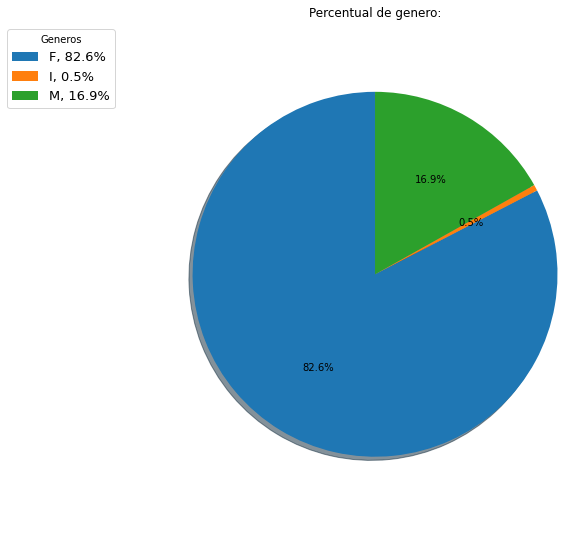

In [25]:
agrupamento_por_genero = df['genero_tratado'].groupby([df['genero_tratado']]).count() 
labels = ['F', 'I', 'M']
fig1, ax1 = plt.subplots(figsize=(8,7))
fig1.subplots_adjust(0.3,0,1,1)
ax1.pie(agrupamento_por_genero, autopct='%0.1f%%',frame=False,shadow=True, startangle=90) #radius=180000,autopct='%0.01f%%'

total = sum(agrupamento_por_genero)
ax1.legend(  
           title='Generos',
           loc = 'upper left',
           labels=['%s, %1.1f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, agrupamento_por_genero)],
           bbox_to_anchor=(0.0, 1),
           prop={'size': 13},
           bbox_transform=fig1.transFigure)
ax1.axis('equal')
plt.xticks(fontsize=1)
ax1.set_title('Percentual de genero:')
plt.show()

### Quantidade de aberturas e não aberturas por genero.

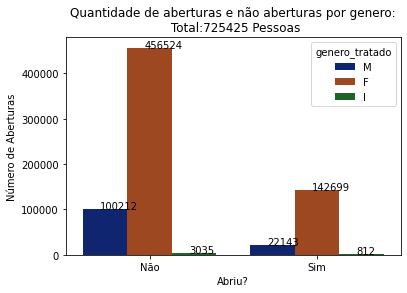

In [26]:
pessoas = sns.countplot(data = df, x ='abriu?', hue ='genero_tratado',palette='dark')
for p in pessoas.patches:
  b =p.get_bbox()
  pessoas.annotate("{:.0f}".format(b.y1+b.y0),((b.x0 + b.x1)/2 -0.03,b.y1+15))

plt.title('Quantidade de aberturas e não aberturas por genero:\n Total:%s Pessoas' %(df.shape[0]))
plt.xlabel('Abriu?')
plt.ylabel('Número de Aberturas')
plt.show()

### Quantidade de envios por genero

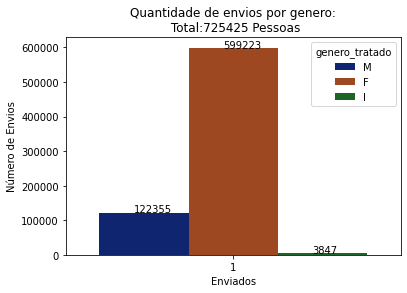

In [27]:
pessoas = sns.countplot(data = df, x ='Envios', hue ='genero_tratado',palette='dark')
for p in pessoas.patches:
  b =p.get_bbox()
  pessoas.annotate("{:.0f}".format(b.y1+b.y0),((b.x0 + b.x1)/2 -0.03,b.y1+15))

plt.title('Quantidade de envios por genero:\n Total:%s Pessoas' %(df.shape[0]))
plt.xlabel('Enviados')
plt.ylabel('Número de Envios')
plt.show()

### Proporção de abertura por genero (masculino, feminino e indefinido) com mais facilidade.

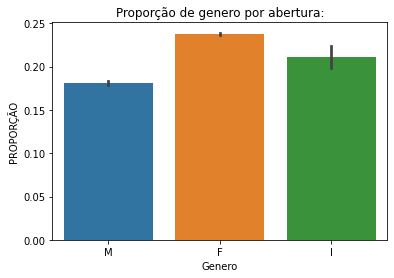

In [28]:
abertura_classe = df.copy()
abertura_classe['abriu?'] = df['abriu?'] == 'Sim'

sns.barplot(data=abertura_classe, y='abriu?', x='genero_tratado')
plt.title('Proporção de genero por abertura:')
plt.ylabel('PROPORÇÃO')
plt.xlabel('Genero')
plt.show()

In [29]:
df[df['abriu?'] == 'Sim']['genero_tratado'].value_counts().sort_values(ascending=True)

I       812
M     22143
F    142699
Name: genero_tratado, dtype: int64

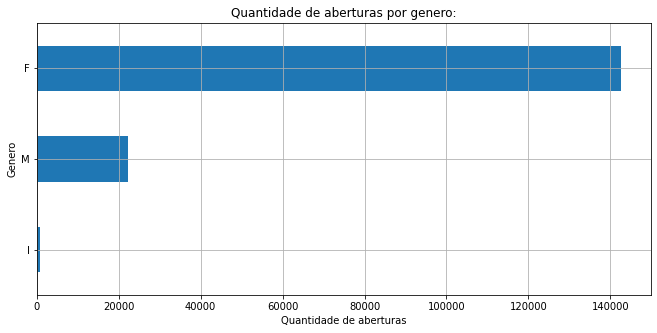

In [30]:
genero_por_abertura = df[df['abriu?'] == 'Sim']['genero_tratado'].value_counts().sort_values(ascending=True)

genero_por_abertura
genero_por_abertura.plot(kind='barh',figsize=(11,5),rot=0,grid=True)

plt.title('Quantidade de aberturas por genero:')
plt.xlabel('Quantidade de aberturas')
plt.ylabel('Genero')
plt.show()  

### Gerar matriz de correlação

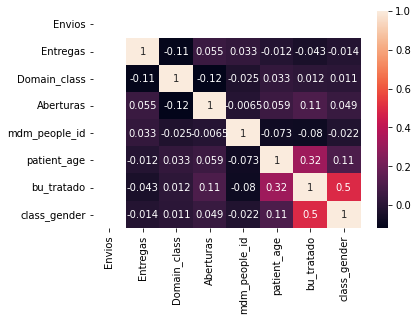

In [31]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Modelos 

## Preparando a Base para os modelos.

In [32]:
df[:1].values

array([['FERNANDOHENRIQU26121992', 1, 1, 'telefonica.com', 0,
        'DASA - SP', 0, 6070482, 29, 'M', 'FERNANDOHENRIQU26121992', 0,
        'Não', 'M', 1.0]], dtype=object)

In [33]:
df.columns

Index(['SubscriberKey', 'Envios', 'Entregas', 'DomainSent', 'Domain_class',
       'BU', 'Aberturas', 'mdm_people_id', 'patient_age', 'origin_gender',
       'pacid', 'bu_tratado', 'abriu?', 'genero_tratado', 'class_gender'],
      dtype='object')

Separação de:
* x = Features (variaveis)
* y = Valor previsto

In [34]:
X = df[['Entregas', 'Domain_class', 'bu_tratado','class_gender','patient_age']]
y = df[['Aberturas']]

Separação de bases para treino e teste:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
X_train.head()
# X_train.info()

,Entregas,Domain_class,bu_tratado,class_gender,patient_age
688260,1,1,1,2.0,71
81496,1,0,0,2.0,34
284572,1,1,1,2.0,45
324846,1,1,0,1.0,55
1524080,1,4,1,2.0,40


In [37]:
y_train.head()

,Aberturas
688260,0
81496,1
284572,1
324846,1
1524080,0


## Aplicando Modelo de Vetor de Suporte:

In [38]:
svc_model = LinearSVC()
svc_model.fit(X_train,y_train)

LinearSVC()

In [39]:
predito_svc = svc_model.predict(X_test)
predito_svc

array([0, 0, 0, ..., 0, 0, 0])

## Método baseado na proximidade
Modelo K-nearest neighbors (KNN)

In [40]:
norm = StandardScaler()
X_normalizado = norm.fit_transform(X)
X_normalizado

array([[ 0.10130366, -1.23708374, -1.22239143, -2.06646234, -1.44125536],
       [ 0.10130366, -1.23708374, -1.22239143, -2.06646234, -0.99653222],
       [ 0.10130366,  3.91689569, -1.22239143,  0.45138091, -0.18120648],
       ...,
       [ 0.10130366,  1.05357379,  0.81806856,  0.45138091,  0.48587822],
       [ 0.10130366,  1.05357379, -1.22239143, -2.06646234,  1.89416815],
       [ 0.10130366,  1.05357379, -1.22239143,  0.45138091,  0.85648084]])

In [41]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_normalizado, y, test_size=0.3, random_state=42)

In [42]:
knn_model = KNeighborsClassifier(metric='euclidean')

In [43]:
knn_model.fit(X_treino, y_treino)

KNeighborsClassifier(metric='euclidean')

In [44]:
predito_knn = knn_model.predict(X_teste)
predito_knn

array([0, 0, 0, ..., 0, 1, 0])

## Método Probabilístico

### Aplicando Modelo de Regressão Logistica:

In [45]:
logReg_model = LogisticRegression(penalty='none', solver='newton-cg')

In [46]:
logReg_model.fit(X_train, y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [80]:
predito_regLog = logReg_model.predict(X_test)

In [78]:
# Predizendo as probabilidades
predito_proba_regLog = logReg_model.predict_proba(X_test)
print(predito_proba_regLog)

[[0.70180987 0.29819013]
 [0.81894178 0.18105822]
 [0.8136878  0.1863122 ]
 ...
 [0.67424461 0.32575539]
 [0.69935973 0.30064027]
 [0.64997344 0.35002656]]


In [48]:
# predito_regLog = predito_regLog[:, 1] # manter somente para a classe positiva

In [49]:
# confusion_matrix(y, model.predict(X)) # usando a função do sklearn

In [90]:
print(classification_report(y_test,predito_regLog))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    167848
           1       0.00      0.00      0.00     49780

    accuracy                           0.77    217628
   macro avg       0.39      0.50      0.44    217628
weighted avg       0.59      0.77      0.67    217628



In [51]:
# teste = pd.DataFrame({'Envios':10, 'Entregas':6, 'Domain_class':3, 'bu_tratado':1}, index=[0])

In [52]:
# teste = pd.DataFrame({'Envios':10, 'Entregas':6, 'Domain_class':3, 'bu_tratado':1}, index=[0])
# minha_prob = logReg_model.predict_proba(teste)
# print(round(minha_prob[:,1][0]*100, 2))

###  Modelo Bernoulli Naive Bayes


In [53]:
bnb_model = BernoulliNB(binarize=-0.44)

In [54]:
#escolho utilizar mediana, porque é o valor central dos nossos dados ordenados
np.median(X_train)

1.0

In [55]:
#treinar o modelo
bnb_model.fit(X_train, y_train)

BernoulliNB(binarize=-0.44)

In [56]:
#testar o modelo
predito_BNb = bnb_model.predict(X_test)
predito_BNb

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
print(classification_report(y_test, predito_BNb))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    167848
           1       0.00      0.00      0.00     49780

    accuracy                           0.77    217628
   macro avg       0.39      0.50      0.44    217628
weighted avg       0.59      0.77      0.67    217628



## Método Simbólico

### Árvore de decisão

In [57]:
#instanciando o modelo
dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [58]:
#treinar o modelo
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [59]:
predito_ArvoreDecisao = dtc_model.predict(X_test)
predito_ArvoreDecisao

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
# export_graphviz(modelo)
# dot_data = export_graphviz(modelo, out_file=None)
# grafico = graphviz.Source(dot_data)
# grafico

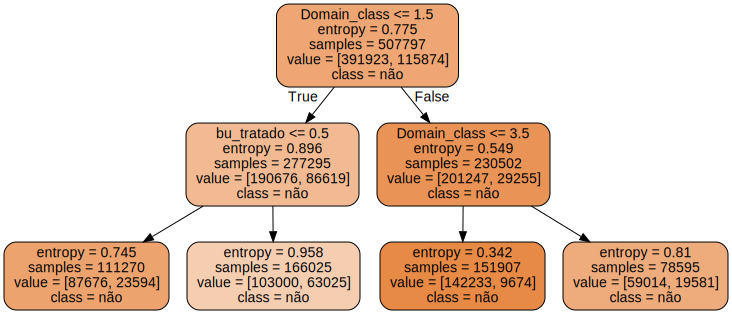

In [174]:
#instanciando o modelo
dtc_model_v2 = DecisionTreeClassifier(criterion='entropy', random_state=42,max_depth=2)
#treinar o modelo
dtc_model_v2.fit(X_train, y_train)
features = X.columns
dot_data = export_graphviz(dtc_model_v2, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

# Validação dos modelos:

## Matriz de confusão: 
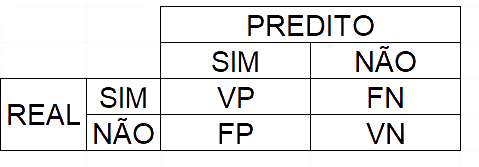

In [81]:
print(f'''
> Matriz SVC: \n {confusion_matrix(y_test, predito_svc)}

> Matriz KNN: \n {confusion_matrix(y_test, predito_knn)}

> Matriz BNB: \n {confusion_matrix(y_test,predito_BNb)}

> Matriz Reg.Log: \n {confusion_matrix(y_test, predito_regLog)}

> Matriz DTC: \n {confusion_matrix(y_test, predito_ArvoreDecisao)}
''')


> Matriz SVC: 
 [[167848      0]
 [ 49780      0]]

> Matriz KNN: 
 [[146241  21607]
 [ 36451  13329]]

> Matriz BNB: 
 [[167848      0]
 [ 49780      0]]

> Matriz Reg.Log: 
 [[167848      0]
 [ 49780      0]]

> Matriz DTC: 
 [[167279    569]
 [ 48675   1105]]



## Acurácia
acurária - Quanto o modelo está acertando

In [83]:
acerto_svc = accuracy_score(y_test, predito_svc)
acerto_knn = accuracy_score(y_test, predito_knn)
acerto_bnb = accuracy_score(y_test, predito_BNb)
acerto_regLog = accuracy_score(y_test, predito_regLog)
acerto_ArvoreDecisao = accuracy_score(y_test, predito_ArvoreDecisao)
print(f'''
Acurácia do SVC: {acerto_svc}
Acurácia do KNN: {acerto_knn}
Acurácia do BNb: {acerto_bnb}
Acurácia da Reg.log: {acerto_regLog}
Acurácia da DTC: {acerto_ArvoreDecisao}
''')


Acurácia do SVC: 0.7712610509677064
Acurácia do KNN: 0.7332236660723804
Acurácia do BNb: 0.7712610509677064
Acurácia da Reg.log: 0.7712610509677064
Acurácia da DTC: 0.7737239693421802



## Precisão:
precisão - Quantos foram classificados corretamento como positivos ($TP$).

In [86]:
print(f'''
    > Precisão SVC: {precision_score(y_test, predito_svc)}
    > Precisão KNN: {precision_score(y_teste, predito_knn)}
    > Precisão BNB: {precision_score(y_test, predito_BNb)}
    > Precisão da RegLog: {precision_score(y_test, predito_regLog)}
    > Precisão da ArvoreDecisao = {precision_score(y_test, predito_ArvoreDecisao)}
    ''')


    > Precisão SVC: 0.0
    > Precisão KNN: 0.381526219372567
    > Precisão BNB: 0.0
    > Precisão da RegLog: 0.0
    > Precisão da ArvoreDecisao = 0.6600955794504182
    


## Recall:
sensibilidade: Quão bom o modelo está para classificar corretamente um resultado positivo ($TP$).

In [87]:
print(f'''
    > Sensibilidade SVC: {recall_score(y_test, predito_svc)}
    > Sensibilidade KNN: {recall_score(y_teste, predito_knn)}
    > Sensibilidade BNB: {recall_score(y_test, predito_BNb)}
    > Sensibilidade da RegLog: {recall_score(y_test, predito_regLog)}
    > Sensibilidade da ArvoreDecisao = {recall_score(y_test, predito_ArvoreDecisao)}
    ''')


    > Sensibilidade SVC: 0.0
    > Sensibilidade KNN: 0.26775813579750907
    > Sensibilidade BNB: 0.0
    > Sensibilidade da RegLog: 0.0
    > Sensibilidade da ArvoreDecisao = 0.0221976697468863
    


## Outros Métodos

In [91]:
print(classification_report(y_test, predito_BNb))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    167848
           1       0.00      0.00      0.00     49780

    accuracy                           0.77    217628
   macro avg       0.39      0.50      0.44    217628
weighted avg       0.59      0.77      0.67    217628



In [92]:
print(classification_report(y_test, predito_svc))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    167848
           1       0.00      0.00      0.00     49780

    accuracy                           0.77    217628
   macro avg       0.39      0.50      0.44    217628
weighted avg       0.59      0.77      0.67    217628



In [94]:
print(classification_report(y_teste, predito_knn))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83    167848
           1       0.38      0.27      0.31     49780

    accuracy                           0.73    217628
   macro avg       0.59      0.57      0.57    217628
weighted avg       0.70      0.73      0.72    217628



In [95]:
print(classification_report(y_teste, predito_regLog))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    167848
           1       0.00      0.00      0.00     49780

    accuracy                           0.77    217628
   macro avg       0.39      0.50      0.44    217628
weighted avg       0.59      0.77      0.67    217628



In [96]:
print(classification_report(y_teste, predito_ArvoreDecisao))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    167848
           1       0.66      0.02      0.04     49780

    accuracy                           0.77    217628
   macro avg       0.72      0.51      0.46    217628
weighted avg       0.75      0.77      0.68    217628



# Testes Específicos de probabilidade

In [97]:
X_train.head()

,Entregas,Domain_class,bu_tratado,class_gender,patient_age
688260,1,1,1,2.0,71
81496,1,0,0,2.0,34
284572,1,1,1,2.0,45
324846,1,1,0,1.0,55
1524080,1,4,1,2.0,40


In [163]:
persona_x = pd.DataFrame({
    'Entregas':1, 
    'Domain_class':2, 
    'bu_tratado':1,
    'class_gender':2,
    'patient_age':40
    }, index=[0])

In [164]:
prob_persona_x_logReg = logReg_model.predict_proba(persona_x)
prob_persona_x_BNb = bnb_model.predict_proba(persona_x)
prob_persona_x_knn = knn_model.predict_proba(persona_x)

print(
    f'''
    ->Percentual de abertura com regressão logística: {round(prob_persona_x_logReg[:,1][0]*100, 2)}

    ->Percentual de abertura com Naive Bayes: {round(prob_persona_x_BNb[:,1][0]*100, 2)}

    ->Percentual de abertura com KNN: {round(prob_persona_x_knn[:,1][0]*100, 2)}
    ''')


    ->Percentual de abertura com regressão logística: 25.66

    ->Percentual de abertura com Naive Bayes: 22.82

    ->Percentual de abertura com KNN: 20.0
    


array([[0.8, 0.2]])

In [157]:
df_simulation = df.copy()
df_simulation['chance_abertura_logReg'] = 0
df_simulation['chance_abertura_BnB'] = 0

In [158]:
for index in df_simulation.index:
  persona_sim = pd.DataFrame({
    'Entregas': df_simulation['Entregas'][index], 
    'Domain_class': df_simulation['Domain_class'][index], 
    'bu_tratado': df_simulation['bu_tratado'][index],
    'class_gender': df_simulation['class_gender'][index],
    'patient_age': df_simulation['patient_age'][index]
    }, index=[0])
  persona_x_logReg = logReg_model.predict_proba(persona_sim)
  prob_persona_x_BNb = bnb_model.predict_proba(persona_sim)
  df_simulation['chance_abertura_logReg'][index] = round(persona_x_logReg[:,1][0]*100, 2)
  df_simulation['chance_abertura_BnB'][index] = round(prob_persona_x_BNb[:,1][0]*100, 2)
  

In [160]:
df_simulation.shape

(725425, 17)

In [161]:
df_simulation.to_csv('dataset_with_open_percent.csv',sep=';',encoding='utf-8')

In [162]:
df_simulation.head()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid,bu_tratado,abriu?,genero_tratado,class_gender,chance_abertura_logReg,chance_abertura_BnB
0,FERNANDOHENRIQU26121992,1,1,telefonica.com,0,DASA - SP,0,6070482,29,M,FERNANDOHENRIQU26121992,0,Não,M,1.0,22,22
1,RODRIGOLIMAMART01091986,1,1,dellacont.com.br,0,DASA - SP,1,17821409,35,M,RODRIGOLIMAMART01091986,0,Sim,M,1.0,22,22
3,MILENARODRIGUES17011976,1,1,terra.com.br,9,DASA - SP,1,6772987,46,F,MILENARODRIGUES17011976,0,Sim,F,2.0,5,22
5,PERCIVALARMANDO22011956,1,1,metaambiental.eng.br,0,DASA - SP,1,7565607,66,M,PERCIVALARMANDO22011956,0,Sim,M,1.0,26,22
7,THIAGODESOUZAME28101980,1,1,me.com,12,DASA - SP,0,6706854,41,M,THIAGODESOUZAME28101980,0,Não,M,1.0,2,22


In [166]:
df_simulation.columns

Index(['SubscriberKey', 'Envios', 'Entregas', 'DomainSent', 'Domain_class',
       'BU', 'Aberturas', 'mdm_people_id', 'patient_age', 'origin_gender',
       'pacid', 'bu_tratado', 'abriu?', 'genero_tratado', 'class_gender',
       'chance_abertura_logReg', 'chance_abertura_BnB'],
      dtype='object')

In [167]:
df_simulation[['SubscriberKey','abriu?','chance_abertura_logReg', 'chance_abertura_BnB']].head(20)

,SubscriberKey,abriu?,chance_abertura_logReg,chance_abertura_BnB
0,FERNANDOHENRIQU26121992,Não,22,22
1,RODRIGOLIMAMART01091986,Sim,22,22
3,MILENARODRIGUES17011976,Sim,5,22
5,PERCIVALARMANDO22011956,Sim,26,22
7,THIAGODESOUZAME28101980,Não,2,22
8,CARMENFERNANDAV25041976,Sim,19,22
9,REGINACELIADASI05051960,Não,36,22
10,VERADAPENHAMART01121953,Sim,37,22
11,JOSELMASILVAGON28121975,Sim,34,22
12,RAQUELGUADAGNOL27071974,Não,19,22


In [143]:
# persona_x_logRed = logReg_model.predict(persona_x)
# persona_x_BNb = bnb_model.predict(persona_x)

# print(persona_x_logRed,persona_x_BNb)

[0] [0]


In [129]:
# prob_persona_x_BNb
# 0.77


array([[0.77181574, 0.22818426]])

[0] [0]
